**This notebooks shows three ways of training a model on TPU:**
1. Using Keras and model.fit()
1. Using a custom training loop
1. Using a custom training loop specifically optimized for TPU

**Optimization that benefit all three models:**

- use `dataset.batch(BATCH_SIZE, drop_remainder=True)`<br/>
   The training dataset is infinitely repeated so drop_remainder=True should not be needed. However, whith the setting, Tensorflow produces batches of a known size and although XLA (the TPU compiler) can now handle variable batches, it is slightly faster on fixed batches.<br/>
   On the validation dataset, this setting can drop some validation images. It is not the case here because the validation dataset happens to contain an integral number of batches.
   
**Optimizations specific to the TPU-optimized custom training loop:**

- The training and validation step functions run multiple batches at once. This is achieved by placing a loop using `tf.range()` in the step function. The loop will be compiled to (thanks to `@tf.function`) and executed on TPU.
- The validation dataset is made to repeat indefinitely because handling end-of-dataset exception in a TPU loop implemented with `tf.range()` is not yet possible. Validation is adjusted to always use exactly or more than the entire validation dataset. This could change numerics. It happens that in this example, the validation dataset is used exactly once per validation.
- The validation dataset iterator is not reset between validation runs. Since the iterator is passed into the step function which is then compiled for TPU (thanks to `@tf.function`), passing a fresh iterator for every validation run would trigger a fresh recompilation. With a validation at the end of every epoch this would be slow.
- Losses are reported through Keras metrics. It is possible to return values from step function and return losses in that way. However, in the optimized version of the custom training loop, using `tf.range()`, aggregating losses returned from multiple batches becomes impractical.

In [1]:
import math, re, os, time
import tensorflow as tf
import numpy as np
from collections import namedtuple
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.4.0


# TPU or GPU detection

In [2]:
# NEW on TPU in TensorFlow 24: shorter cross-compatible TPU/GPU/multi-GPU/cluster-GPU detection code

try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

Number of accelerators:  8


# Competition data access
TPUs read data directly from Google Cloud Storage (GCS). This Kaggle utility will copy the dataset to a GCS bucket co-located with the TPU. If you have multiple datasets attached to the notebook, you can pass the name of a specific dataset to the get_gcs_path function. The name of the dataset is the name of the directory it is mounted in. Use `!ls /kaggle/input/` to list attached datasets.

In [3]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path() # you can list the bucket with "!gsutil ls $GCS_DS_PATH"

# Configuration

Learning rate schedule: 1e-05 to 0.0004 to 0.000112


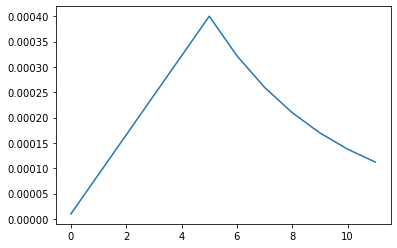

In [4]:
IMAGE_SIZE = [512, 512] # At this size, a GPU will run out of memory. Use the TPU.
                        # For GPU training, please select 224 x 224 px image size.
EPOCHS = 12
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5.0
LR_SUSTAIN_EPOCHS = 0.0
LR_EXP_DECAY = .8
        
@tf.function
def lrfn(epoch):
    if float(epoch) < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * float(epoch) + LR_START
    elif float(epoch) < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(float(epoch) - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

## Visualization utilities
data -> pixels, nothing of much interest for the machine learning practitioner in this section.

In [5]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    #plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        #plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# Datasets

In [6]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3) # image format uint8 [0,255]
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False, repeated=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=repeated) # slighly faster with fixed tensor sizes
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

def int_div_round_up(a, b):
    return (a + b - 1) // b

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALIDATION_STEPS = int_div_round_up(NUM_VALIDATION_IMAGES, BATCH_SIZE)
TEST_STEPS = int_div_round_up(NUM_TEST_IMAGES, BATCH_SIZE)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


# Dataset visualizations

In [7]:
# Peek at training data
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

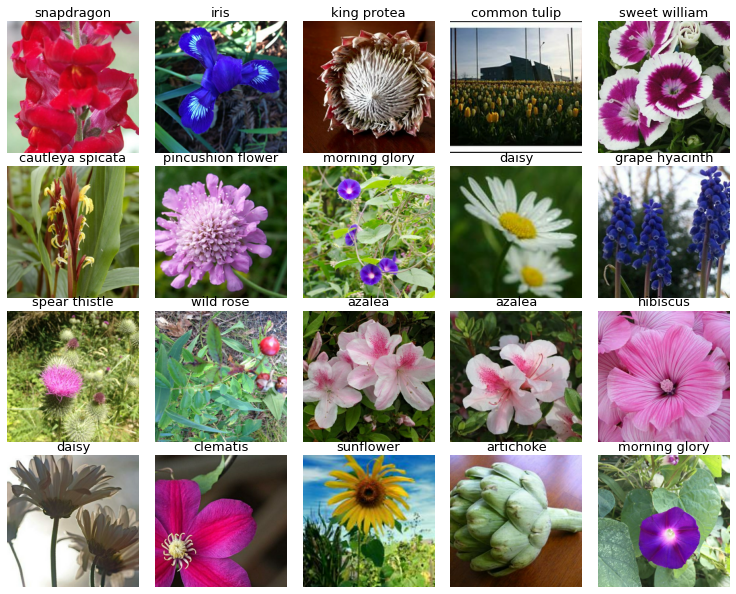

In [8]:
# run this cell again for next set of images
display_batch_of_images(next(train_batch))

In [9]:
# peer at test data
test_dataset = get_test_dataset()
test_dataset = test_dataset.unbatch().batch(20)
test_batch = iter(test_dataset)

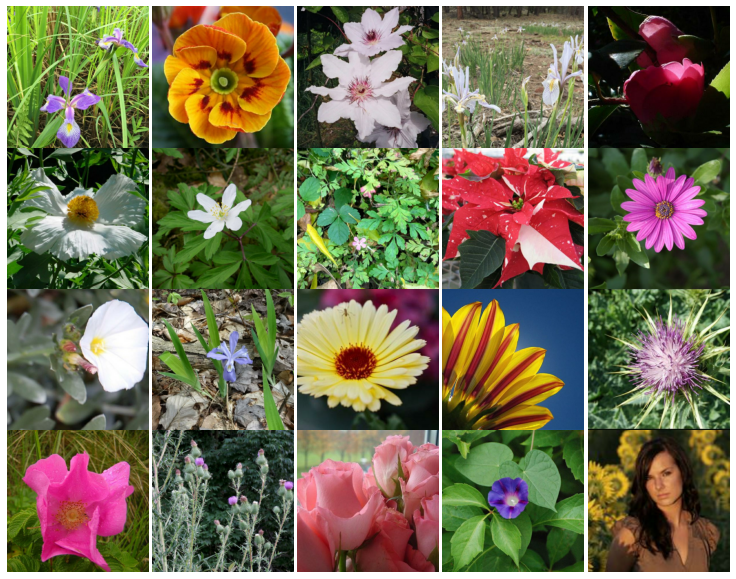

In [10]:
# run this cell again for next set of images
display_batch_of_images(next(test_batch))

# Keras training
## Model

In [11]:
with strategy.scope():
    pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
    pretrained_model.trainable = True # False = transfer learning, True = fine-tuning
    
    model = tf.keras.Sequential([
        # convert image format from int [0,255] to the format expected by this model
        tf.keras.layers.Lambda(lambda data: tf.keras.applications.xception.preprocess_input(tf.cast(data, tf.float32)), input_shape=[*IMAGE_SIZE, 3]),
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
        
    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'],
        # NEW on TPU in TensorFlow 24: sending multiple batches to the TPU at once saves communications
        # overheads and allows the XLA compiler to unroll the loop on TPU and optimize hardware utilization.
        steps_per_execution=16
    )
    
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)
    
    model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 512, 512, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               213096    
Total params: 21,074,576
Trainable params: 21,020,048
Non-trainable params: 54,528
_________________________________________________________________


## Training

In [12]:
start_time = time.time()

history = model.fit(get_training_dataset(), steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS,
                    validation_data=get_validation_dataset(), validation_steps=VALIDATION_STEPS,
                    callbacks=[lr_callback])

keras_fit_training_time = time.time() - start_time
print("KERAS FIT TRAINING TIME: {:0.1f}s".format(keras_fit_training_time))

Epoch 1/12

Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(1e-05, shape=(), dtype=float32).
99/99 [==============================] - 79s 796ms/step - loss: 4.5691 - sparse_categorical_accuracy: 0.0439 - val_loss: 4.1782 - val_sparse_categorical_accuracy: 0.1708
Epoch 2/12

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(8.8e-05, shape=(), dtype=float32).
99/99 [==============================] - 23s 232ms/step - loss: 3.1371 - sparse_categorical_accuracy: 0.3715 - val_loss: 1.4121 - val_sparse_categorical_accuracy: 0.6802
Epoch 3/12

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.000166, shape=(), dtype=float32).
99/99 [==============================] - 23s 233ms/step - loss: 1.1581 - sparse_categorical_accuracy: 0.7622 - val_loss: 0.5512 - val_sparse_categorical_accuracy: 0.8653
Epoch 4/12

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.000244, shape=(), dtype=float32).
99/99 [===========

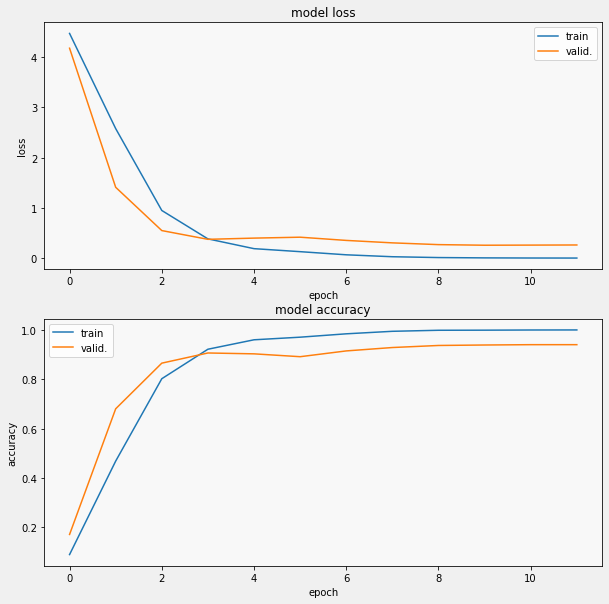

In [13]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

# Custom training loop
## Model

In [14]:
with strategy.scope():
    pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
    pretrained_model.trainable = True # False = transfer learning, True = fine-tuning
    
    model = tf.keras.Sequential([
        # convert image format from int [0,255] to the format expected by this model
        tf.keras.layers.Lambda(lambda data: tf.keras.applications.xception.preprocess_input(tf.cast(data, tf.float32)), input_shape=[*IMAGE_SIZE, 3]),
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    model.summary()
    
    # Instiate optimizer with learning rate schedule
    class LRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
        def __call__(self, step):
            return lrfn(epoch=step//STEPS_PER_EPOCH)
    optimizer = tf.keras.optimizers.Adam(learning_rate=LRSchedule())
        
    # this also works but is not very readable
    # optimizer = tf.keras.optimizers.Adam(learning_rate=lambda: lrfn(tf.cast(optimizer.iterations, tf.float32)//STEPS_PER_EPOCH))
    
    # Instantiate metrics
    train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    train_loss = tf.keras.metrics.Sum()
    valid_loss = tf.keras.metrics.Sum()
    
    # loss as recommended by the custom training loop Tensorflow documentation:
    # https://www.tensorflow.org/tutorials/distribute/custom_training#define_the_loss_function
    # Here, a simpler loss_fn = tf.keras.losses.sparse_categorical_crossentropy would work the same.
    loss_fn = lambda a,b: tf.nn.compute_average_loss(tf.keras.losses.sparse_categorical_crossentropy(a,b), global_batch_size=BATCH_SIZE)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 512, 512, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 104)               213096    
Total params: 21,074,576
Trainable params: 21,020,048
Non-trainable params: 54,528
_________________________________________________________________


## Step functions

In [15]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        probabilities = model(images, training=True)
        loss = loss_fn(labels, probabilities)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    # update metrics
    train_accuracy.update_state(labels, probabilities)
    train_loss.update_state(loss)

@tf.function
def valid_step(images, labels):
    probabilities = model(images, training=False)
    loss = loss_fn(labels, probabilities)
    
    # update metrics
    valid_accuracy.update_state(labels, probabilities)
    valid_loss.update_state(loss)

## Training loop

In [16]:
start_time = epoch_start_time = time.time()

# distribute the datset according to the strategy
train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset())
valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset())

print("Steps per epoch:", STEPS_PER_EPOCH)
History = namedtuple('History', 'history')
history = History(history={'loss': [], 'val_loss': [], 'sparse_categorical_accuracy': [], 'val_sparse_categorical_accuracy': []})

epoch = 0
for step, (images, labels) in enumerate(train_dist_ds):
    
    # run training step
    strategy.run(train_step, args=(images, labels))
    print('=', end='', flush=True)

    # validation run at the end of each epoch
    if ((step+1) // STEPS_PER_EPOCH) > epoch:
        print('|', end='', flush=True)
        
        # validation run
        for image, labels in valid_dist_ds:
            strategy.run(valid_step, args=(image, labels))
            print('=', end='', flush=True)

        # compute metrics
        history.history['sparse_categorical_accuracy'].append(train_accuracy.result().numpy())
        history.history['val_sparse_categorical_accuracy'].append(valid_accuracy.result().numpy())
        history.history['loss'].append(train_loss.result().numpy() / STEPS_PER_EPOCH)
        history.history['val_loss'].append(valid_loss.result().numpy() / VALIDATION_STEPS)
        
        # report metrics
        epoch_time = time.time() - epoch_start_time
        print('\nEPOCH {:d}/{:d}'.format(epoch+1, EPOCHS))
        print('time: {:0.1f}s'.format(epoch_time),
              'loss: {:0.4f}'.format(history.history['loss'][-1]),
              'accuracy: {:0.4f}'.format(history.history['sparse_categorical_accuracy'][-1]),
              'val_loss: {:0.4f}'.format(history.history['val_loss'][-1]),
              'val_acc: {:0.4f}'.format(history.history['val_sparse_categorical_accuracy'][-1]),
              'lr: {:0.4g}'.format(lrfn(epoch)), flush=True)
        
        # set up next epoch
        epoch = (step+1) // STEPS_PER_EPOCH
        epoch_start_time = time.time()
        train_accuracy.reset_states()
        valid_accuracy.reset_states()
        valid_loss.reset_states()
        train_loss.reset_states()
        
        if epoch >= EPOCHS:
            break
    
simple_ctl_training_time = time.time() - start_time
print("SIMPLE CTL TRAINING TIME: {:0.1f}s".format(simple_ctl_training_time))

Steps per epoch: 99
===================================================================================================|=============================
EPOCH 1/12
time: 78.3s loss: 4.4490 accuracy: 0.1027 val_loss: 4.1455 val_acc: 0.1848 lr: 1e-05
===================================================================================================|=============================
EPOCH 2/12
time: 26.9s loss: 2.5780 accuracy: 0.4677 val_loss: 1.4046 val_acc: 0.6767 lr: 8.8e-05
===================================================================================================|=============================
EPOCH 3/12
time: 26.7s loss: 0.9469 accuracy: 0.8044 val_loss: 0.5371 val_acc: 0.8683 lr: 0.000166
===================================================================================================|=============================
EPOCH 4/12
time: 26.6s loss: 0.3874 accuracy: 0.9199 val_loss: 0.4116 val_acc: 0.8984 lr: 0.000244
====================================================================

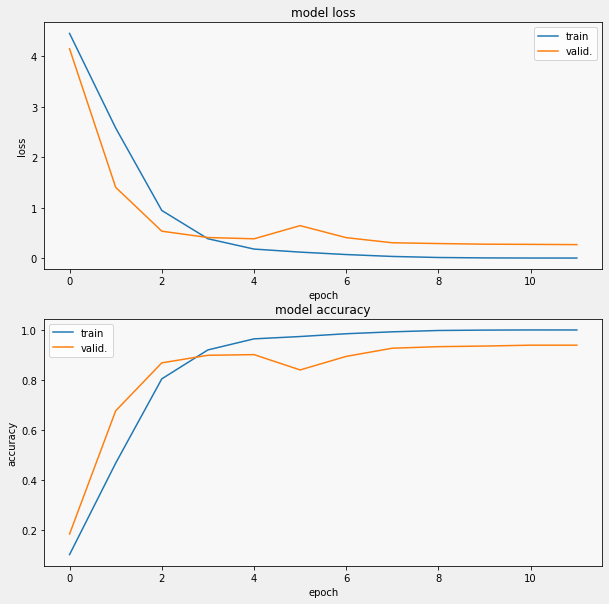

In [17]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

# Optimized custom training loop
Optimized by calling the TPU less often and performing more steps per call
## Model

In [18]:
with strategy.scope():
    pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
    pretrained_model.trainable = True # False = transfer learning, True = fine-tuning
    
    model = tf.keras.Sequential([
        # convert image format from int [0,255] to the format expected by this model
        tf.keras.layers.Lambda(lambda data: tf.keras.applications.xception.preprocess_input(tf.cast(data, tf.float32)), input_shape=[*IMAGE_SIZE, 3]),
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    model.summary()
    
    # Instiate optimizer with learning rate schedule
    class LRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
        def __call__(self, step):
            return lrfn(epoch=step//STEPS_PER_EPOCH)
    optimizer = tf.keras.optimizers.Adam(learning_rate=LRSchedule())
        
    # this also works but is not very readable
    #optimizer = tf.keras.optimizers.Adam(learning_rate=lambda: lrfn(tf.cast(optimizer.iterations, tf.float32)//STEPS_PER_EPOCH))
    
    # Instantiate metrics
    train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    train_loss = tf.keras.metrics.Sum()
    valid_loss = tf.keras.metrics.Sum()
    
    # Loss
    # The recommendation from the Tensorflow custom training loop  documentation is:
    # loss_fn = lambda a,b: tf.nn.compute_average_loss(tf.keras.losses.sparse_categorical_crossentropy(a,b), global_batch_size=BATCH_SIZE)
    # https://www.tensorflow.org/tutorials/distribute/custom_training#define_the_loss_function
    # This works too and shifts all the averaging to the training loop which is easier:
    loss_fn = tf.keras.losses.sparse_categorical_crossentropy

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 512, 512, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 104)               213096    
Total params: 21,074,576
Trainable params: 21,020,048
Non-trainable params: 54,528
_________________________________________________________________


## Step functions

In [19]:
STEPS_PER_TPU_CALL = 99
VALIDATION_STEPS_PER_TPU_CALL = 29

@tf.function
def train_step(data_iter):
    def train_step_fn(images, labels):
        with tf.GradientTape() as tape:
            probabilities = model(images, training=True)
            loss = loss_fn(labels, probabilities)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        #update metrics
        train_accuracy.update_state(labels, probabilities)
        train_loss.update_state(loss)
        
    # this loop runs on the TPU
    for _ in tf.range(STEPS_PER_TPU_CALL):
        strategy.run(train_step_fn, next(data_iter))

@tf.function
def valid_step(data_iter):
    def valid_step_fn(images, labels):
        probabilities = model(images, training=False)
        loss = loss_fn(labels, probabilities)
        
        # update metrics
        valid_accuracy.update_state(labels, probabilities)
        valid_loss.update_state(loss)
        
    # this loop runs on the TPU
    for _ in tf.range(VALIDATION_STEPS_PER_TPU_CALL):
        strategy.run(valid_step_fn, next(data_iter))

## Training loop

In [20]:
start_time = epoch_start_time = time.time()

# distribute the datset according to the strategy
train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset())
# Hitting End Of Dataset exceptions is a problem in this setup. Using a repeated validation set instead.
# This will introduce a slight inaccuracy because the validation dataset now has some repeated elements.
valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(repeated=True))

print("Training steps per epoch:", STEPS_PER_EPOCH, "in increments of", STEPS_PER_TPU_CALL)
print("Validation images:", NUM_VALIDATION_IMAGES,
      "Batch size:", BATCH_SIZE,
      "Validation steps:", NUM_VALIDATION_IMAGES//BATCH_SIZE, "in increments of", VALIDATION_STEPS_PER_TPU_CALL)
print("Repeated validation images:", int_div_round_up(NUM_VALIDATION_IMAGES, BATCH_SIZE*VALIDATION_STEPS_PER_TPU_CALL)*VALIDATION_STEPS_PER_TPU_CALL*BATCH_SIZE-NUM_VALIDATION_IMAGES)
History = namedtuple('History', 'history')
history = History(history={'loss': [], 'val_loss': [], 'sparse_categorical_accuracy': [], 'val_sparse_categorical_accuracy': []})

epoch = 0
train_data_iter = iter(train_dist_ds) # the training data iterator is repeated and it is not reset
                                      # for each validation run (same as model.fit)
valid_data_iter = iter(valid_dist_ds) # the validation data iterator is repeated and it is not reset
                                      # for each validation run (different from model.fit whre the
                                      # recommendation is to use a non-repeating validation dataset)

step = 0
epoch_steps = 0
while True:
    
    # run training step
    train_step(train_data_iter)
    epoch_steps += STEPS_PER_TPU_CALL
    step += STEPS_PER_TPU_CALL
    print('=', end='', flush=True)

    # validation run at the end of each epoch
    if (step // STEPS_PER_EPOCH) > epoch:
        print('|', end='', flush=True)
        
        # validation run
        valid_epoch_steps = 0
        for _ in range(int_div_round_up(NUM_VALIDATION_IMAGES, BATCH_SIZE*VALIDATION_STEPS_PER_TPU_CALL)):
            valid_step(valid_data_iter)
            valid_epoch_steps += VALIDATION_STEPS_PER_TPU_CALL
            print('=', end='', flush=True)

        # compute metrics
        history.history['sparse_categorical_accuracy'].append(train_accuracy.result().numpy())
        history.history['val_sparse_categorical_accuracy'].append(valid_accuracy.result().numpy())
        history.history['loss'].append(train_loss.result().numpy() / (BATCH_SIZE*epoch_steps))
        history.history['val_loss'].append(valid_loss.result().numpy() / (BATCH_SIZE*valid_epoch_steps))
        
        # report metrics
        epoch_time = time.time() - epoch_start_time
        print('\nEPOCH {:d}/{:d}'.format(epoch+1, EPOCHS))
        print('time: {:0.1f}s'.format(epoch_time),
              'loss: {:0.4f}'.format(history.history['loss'][-1]),
              'accuracy: {:0.4f}'.format(history.history['sparse_categorical_accuracy'][-1]),
              'val_loss: {:0.4f}'.format(history.history['val_loss'][-1]),
              'val_acc: {:0.4f}'.format(history.history['val_sparse_categorical_accuracy'][-1]),
              'lr: {:0.4g}'.format(lrfn(epoch)),
              'steps/val_steps: {:d}/{:d}'.format(epoch_steps, valid_epoch_steps), flush=True)
        
        # set up next epoch
        epoch = step // STEPS_PER_EPOCH
        epoch_steps = 0
        epoch_start_time = time.time()
        train_accuracy.reset_states()
        valid_accuracy.reset_states()
        valid_loss.reset_states()
        train_loss.reset_states()
        if epoch >= EPOCHS:
            break

optimized_ctl_training_time = time.time() - start_time
print("OPTIMIZED CTL TRAINING TIME: {:0.1f}s".format(optimized_ctl_training_time))

Training steps per epoch: 99 in increments of 99
Validation images: 3712 Batch size: 128 Validation steps: 29 in increments of 29
Repeated validation images: 0
=|=
EPOCH 1/12
time: 67.7s loss: 4.4471 accuracy: 0.1174 val_loss: 4.1263 val_acc: 0.2077 lr: 1e-05 steps/val_steps: 99/29
=|=
EPOCH 2/12
time: 21.5s loss: 2.5777 accuracy: 0.4609 val_loss: 1.3908 val_acc: 0.6821 lr: 8.8e-05 steps/val_steps: 99/29
=|=
EPOCH 3/12
time: 21.2s loss: 0.9702 accuracy: 0.7951 val_loss: 0.5357 val_acc: 0.8720 lr: 0.000166 steps/val_steps: 99/29
=|=
EPOCH 4/12
time: 20.9s loss: 0.3802 accuracy: 0.9216 val_loss: 0.3921 val_acc: 0.9030 lr: 0.000244 steps/val_steps: 99/29
=|=
EPOCH 5/12
time: 20.9s loss: 0.1850 accuracy: 0.9625 val_loss: 0.4643 val_acc: 0.8828 lr: 0.000322 steps/val_steps: 99/29
=|=
EPOCH 6/12
time: 20.9s loss: 0.1291 accuracy: 0.9711 val_loss: 0.4682 val_acc: 0.8844 lr: 0.0004 steps/val_steps: 99/29
=|=
EPOCH 7/12
time: 20.9s loss: 0.0714 accuracy: 0.9848 val_loss: 0.3735 val_acc: 0.9124 

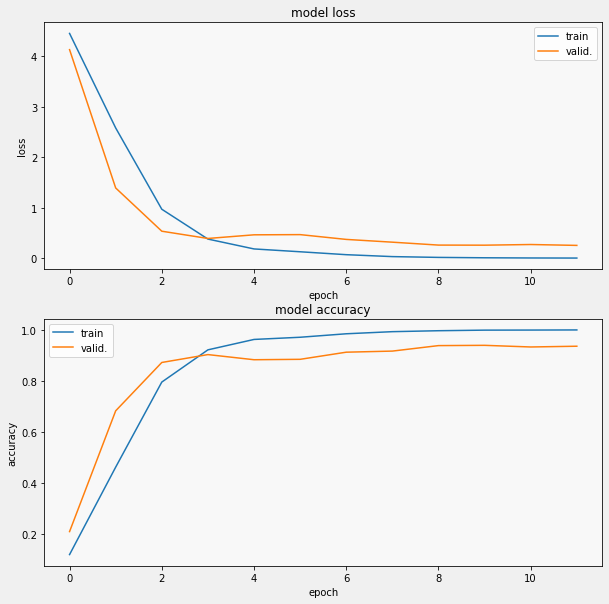

In [21]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

# Confusion matrix

In [22]:
cmdataset = get_validation_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch
cm_probabilities = model.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)
print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
print("Predicted labels: ", cm_predictions.shape, cm_predictions)

Correct   labels:  (3712,) [ 50  13  74 ... 102  48  67]
Predicted labels:  (3712,) [ 50  13  74 ... 102  48  67]


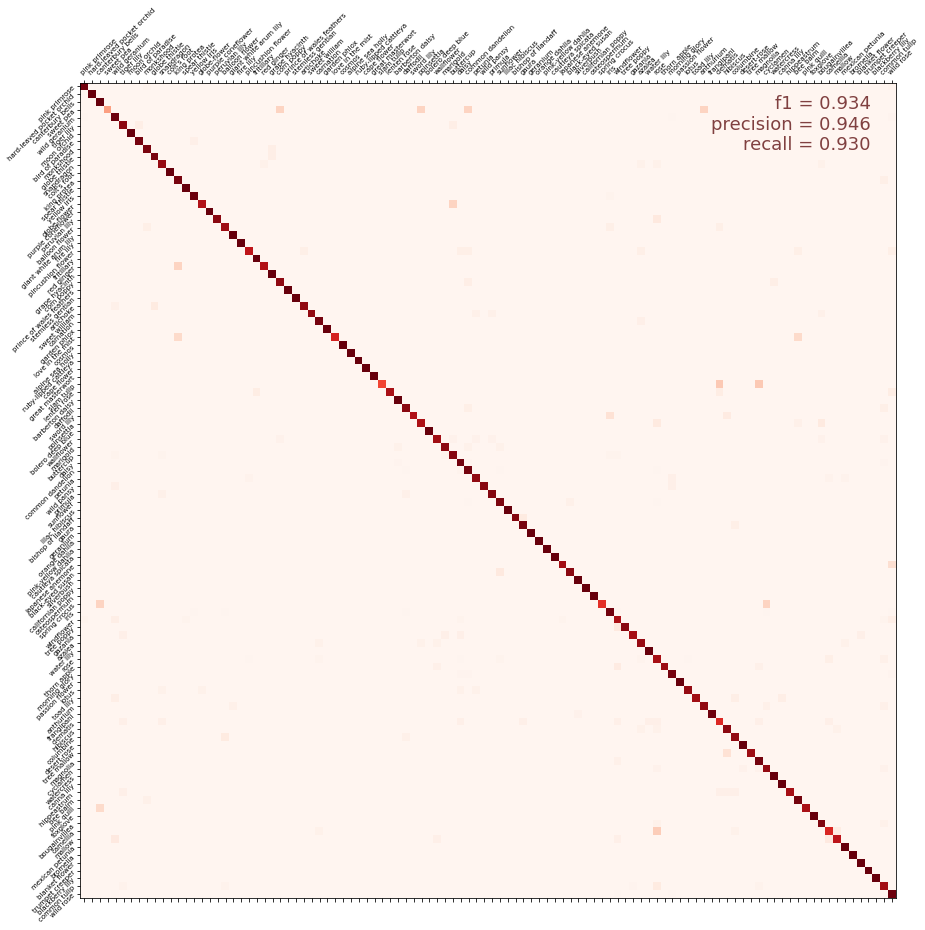

f1 score: 0.934, precision: 0.946, recall: 0.930


In [23]:
cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

# Predictions

In [24]:
test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')
!head submission.csv

Computing predictions...
[ 67  28  83 ...  53 102  62]
Generating submission.csv file...
id,label
252d840db,67
1c4736dea,28
c37a6f3e9,83
00e4f514e,103
59d1b6146,46
8d808a07b,53
aeb67eefb,52
53cfc6586,48
aaa580243,82


# Visual validation

In [25]:
dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)

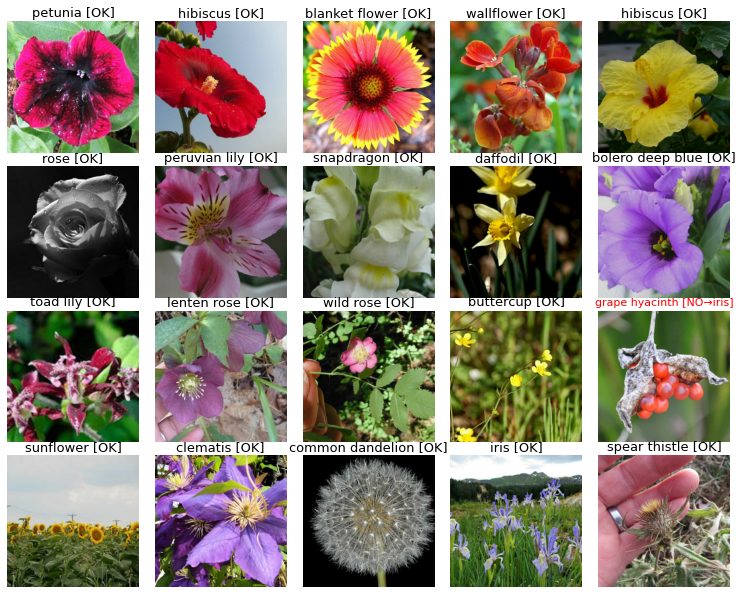

In [26]:
# run this cell again for next set of images
images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)

# Timing summary

In [27]:
print("KERAS FIT TRAINING TIME: {:0.1f}s".format(keras_fit_training_time))
print("SIMPLE CTL TRAINING TIME: {:0.1f}s".format(simple_ctl_training_time))
print("OPTIMIZED CTL TRAINING TIME: {:0.1f}s".format(optimized_ctl_training_time))

KERAS FIT TRAINING TIME: 332.6s
SIMPLE CTL TRAINING TIME: 371.8s
OPTIMIZED CTL TRAINING TIME: 299.0s
